In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile

from qiskit.visualization import *



from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# # Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")


In [2]:
#importing pulse related packages

from qiskit import pulse
from qiskit.pulse import ControlChannel, DriveChannel, Play
from qiskit.pulse.library import Drag
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit_ibm_provider import IBMProvider

import numpy as np
import pandas as pd

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Backend details ##

In [3]:
# Backend details

# Backend details, use IBMqiskitruntimeservice now since IBMProvider got deprecated.



provider = IBMProvider()
provider.backends()
backend = provider.get_backend('ibm_hanoi')
# service = ExperimentData.get_service_from_backend(backend)

conf = backend.configuration()
defs = backend.defaults()
props = backend.properties()

## Accessing Single qubit gates ##

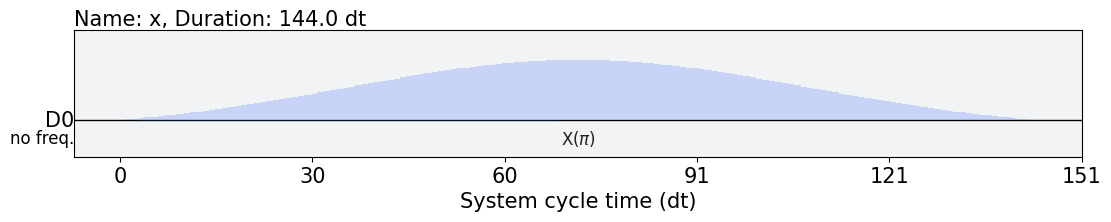

In [4]:
qubit =0
inst_sched_map = defs.instruction_schedule_map
x01_sched = inst_sched_map.get('x', qubits=[qubit])
x01_pulse = x01_sched.instructions[0][1].pulse
sigma = x01_pulse.sigma
angle = x01_pulse.angle

x01_sched.draw()

In [5]:
## Defining all the single qutrit pulses (x12, sx12, rz12)

##Qutrit-0

##Creating the x12 pulse with same parameters as default pulse but with frequency f12##

In [6]:
qubit = 1

inst_sched_map = defs.instruction_schedule_map
x01_sched = inst_sched_map.get('x', qubits=[qubit])
x01_pulse = x01_sched.instructions[0][1].pulse
sigma = x01_pulse.sigma
beta = x01_pulse.beta
angle = x01_pulse.angle
#amp = x01_pulse.amp  ## 0-1 amp for now

pairs_dict = [{key: val} for key, val in conf.control_channels.items() if qubit in key]
ctrl_insts = [[inst_sched_map.get('cx', qubits=pair[0]).filter(channels=pair[1], instruction_types=Play).instructions 
               for pair in pairs.items()] for pairs in pairs_dict]

chan01 = DriveChannel(qubit)
chan_cr = [ctrl_inst for ctrl_inst in ctrl_insts if len(ctrl_inst[0]) > 0][0][0][0][1].channel
chan12 = [list(pair_dict.values()) for pair_dict in pairs_dict if chan_cr not in list(pair_dict.values())[0]][0][0][0]
chan12 = ControlChannel(1)
print(pairs_dict)
print(f'Channels are\n  01 Drive: {chan01}\n  12 Drive: {chan12}\n  Cross Res: {chan_cr}')


[{(0, 1): [ControlChannel(0)]}, {(1, 0): [ControlChannel(1)]}, {(1, 2): [ControlChannel(2)]}, {(1, 4): [ControlChannel(3)]}, {(2, 1): [ControlChannel(4)]}, {(4, 1): [ControlChannel(8)]}]
Channels are
  01 Drive: DriveChannel(1)
  12 Drive: ControlChannel(1)
  Cross Res: ControlChannel(0)


In [7]:
freqs01 = [props.frequency(qidx) for qidx in range(conf.num_qubits)]
anharms = [conf.hamiltonian['vars'][f'delta{qidx}']/(2*np.pi) for qidx in range(conf.num_qubits)]
freqs12 = [freqs01[qidx] + anharms[qidx] for qidx in range(conf.num_qubits)]

dt = backend.dt
sqglen_dt= int(props.gate_length('x', qubits=[0])/dt) # all 1Q gates have same length

In [8]:
amp = 2*7.452953e-02
alpha = -3.419883e+08
beta12 = 2.682730e-01

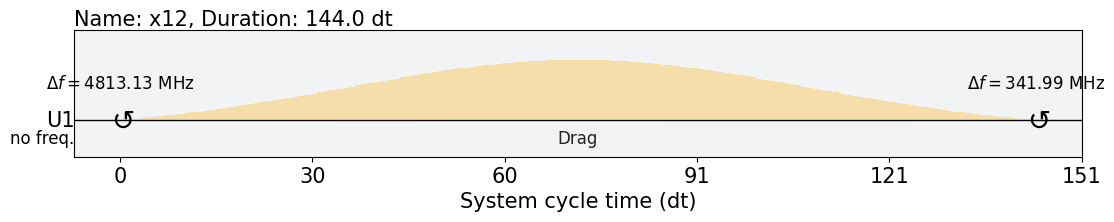

In [9]:
with pulse.build(name='x12') as sched0:
    with pulse.align_sequential():
       
        pulse.set_frequency(freqs01[qubit]+alpha, chan12)
        
        pulse.play(Drag(
            duration=sqglen_dt, 
            sigma=sigma, 
            beta=beta12, 
            amp=amp, 
            angle=angle), 
        chan12)       
        
        pulse.set_frequency(freqs01[qubit], chan12)

sched0.draw()

In [10]:
with pulse.build(name='rz12p') as rzpsched0:
    with pulse.align_sequential():
             pulse.set_frequency(freqs01[qubit]+alpha, chan12)
             pulse.shift_phase(-np.pi/2, chan12)
             pulse.set_frequency(freqs01[qubit], chan12)
                
with pulse.build(name='rz12n') as rznsched0:
    with pulse.align_sequential():
             pulse.set_frequency(freqs01[qubit]+alpha, chan12)
             pulse.shift_phase(np.pi/2, chan12)
             pulse.set_frequency(freqs01[qubit], chan12)

In [11]:
amp = 2*8.274180e-02
alpha = -3.394846e+08
beta12 = -1.315730e+00

In [12]:
## Qutrit-1 ##

In [13]:
qubit = 2

inst_sched_map = defs.instruction_schedule_map
x01_sched = inst_sched_map.get('x', qubits=[qubit])
x01_pulse = x01_sched.instructions[0][1].pulse
sigma = x01_pulse.sigma
beta = x01_pulse.beta
angle = x01_pulse.angle

pairs_dict = [{key: val} for key, val in conf.control_channels.items() if qubit in key]
ctrl_insts = [[inst_sched_map.get('cx', qubits=pair[0]).filter(channels=pair[1], instruction_types=Play).instructions 
               for pair in pairs.items()] for pairs in pairs_dict]

chan01 = DriveChannel(qubit)
chan_cr = [ctrl_inst for ctrl_inst in ctrl_insts if len(ctrl_inst[0]) > 0][0][0][0][1].channel
chan12 = [list(pair_dict.values()) for pair_dict in pairs_dict if chan_cr not in list(pair_dict.values())[0]][0][0][0]
chan12 = ControlChannel(4)
print(f'Channels are\n  01 Drive: {chan01}\n  12 Drive: {chan12}\n  Cross Res: {chan_cr}')
print(pairs_dict)

Channels are
  01 Drive: DriveChannel(2)
  12 Drive: ControlChannel(4)
  Cross Res: ControlChannel(4)
[{(1, 2): [ControlChannel(2)]}, {(2, 1): [ControlChannel(4)]}, {(2, 3): [ControlChannel(5)]}, {(3, 2): [ControlChannel(6)]}]


In [14]:
freqs01 = [props.frequency(qidx) for qidx in range(conf.num_qubits)]
anharms = [conf.hamiltonian['vars'][f'delta{qidx}']/(2*np.pi) for qidx in range(conf.num_qubits)]
freqs12 = [freqs01[qidx] + anharms[qidx] for qidx in range(conf.num_qubits)]

dt = backend.dt
sqglen_dt= int(props.gate_length('x', qubits=[0])/dt) # all 1Q gates have same length


In [15]:
chan12

ControlChannel(4)

In [16]:
with pulse.build(name='x12') as sched1:
    with pulse.align_sequential():
            pulse.set_frequency(freqs01[qubit]+alpha, chan12)
      
            pulse.play(Drag(
                duration=sqglen_dt, 
                sigma=sigma, 
                beta=beta12, 
                amp=amp, 
                angle=angle), 
            chan12)
        
            pulse.set_frequency(freqs01[qubit], chan12)

In [17]:
with pulse.build(name='rz12p') as rzpsched1:
    with pulse.align_sequential():
            pulse.set_frequency(freqs01[qubit]+alpha, chan12)
            pulse.shift_phase(-np.pi/2, chan12)
            pulse.set_frequency(freqs01[qubit], chan12)
                
with pulse.build(name='rz12n') as rznsched1:
    with pulse.align_sequential():
             pulse.set_frequency(freqs01[qubit]+alpha, chan12)
             pulse.shift_phase(np.pi/2, chan12)
             pulse.set_frequency(freqs01[qubit], chan12)

In [18]:
## Creating custom x12,sx12,rz gates and linking the calibration details of all the qutrits ##

In [19]:
qubit = 3
amp = 2.011839e-01
alpha =-3.427423e+08
beta12 = -3.049934e-01

In [22]:
qubit = 3

inst_sched_map = defs.instruction_schedule_map
x01_sched = inst_sched_map.get('x', qubits=[qubit])
x01_pulse = x01_sched.instructions[0][1].pulse
sigma = x01_pulse.sigma
beta = x01_pulse.beta
angle = x01_pulse.angle

pairs_dict = [{key: val} for key, val in conf.control_channels.items() if qubit in key]
ctrl_insts = [[inst_sched_map.get('cx', qubits=pair[0]).filter(channels=pair[1], instruction_types=Play).instructions 
               for pair in pairs.items()] for pairs in pairs_dict]

chan01 = DriveChannel(qubit)
chan_cr = [ctrl_inst for ctrl_inst in ctrl_insts if len(ctrl_inst[0]) > 0][0][0][0][1].channel
chan12 = [list(pair_dict.values()) for pair_dict in pairs_dict if chan_cr not in list(pair_dict.values())[0]][0][0][0]
chan12 = ControlChannel(7)
print(f'Channels are\n  01 Drive: {chan01}\n  12 Drive: {chan12}\n  Cross Res: {chan_cr}')
print(pairs_dict)

Channels are
  01 Drive: DriveChannel(3)
  12 Drive: ControlChannel(7)
  Cross Res: ControlChannel(10)
[{(5, 3): [ControlChannel(10)]}, {(2, 3): [ControlChannel(5)]}, {(3, 2): [ControlChannel(6)]}, {(3, 5): [ControlChannel(7)]}]


In [23]:
with pulse.build(name='x12') as sched2:
    with pulse.align_sequential():
            pulse.set_frequency(freqs01[qubit]+alpha, chan12)
      
            pulse.play(Drag(
                duration=sqglen_dt, 
                sigma=sigma, 
                beta=beta12, 
                amp=amp, 
                angle=angle), 
            chan12)
        
            pulse.set_frequency(freqs01[qubit], chan12)

In [24]:
with pulse.build(name='rz12p') as rzpsched2:
    with pulse.align_sequential():
            pulse.set_frequency(freqs01[qubit]+alpha, chan12)
            pulse.shift_phase(-np.pi/2, chan12)
            pulse.set_frequency(freqs01[qubit], chan12)
                
with pulse.build(name='rz12n') as rznsched2:
    with pulse.align_sequential():
             pulse.set_frequency(freqs01[qubit]+alpha, chan12)
             pulse.shift_phase(np.pi/2, chan12)
             pulse.set_frequency(freqs01[qubit], chan12)

In [25]:
from qiskit import QuantumCircuit


qc = QuantumCircuit(1, name='x12')
qc.x(0)
x12 = qc.to_instruction()



qc = QuantumCircuit(1, name='sx12')
qc.sx(0)
sx12 = qc.to_instruction()


qc = QuantumCircuit(1, name='rz12p')
qc.rz(0,0)
rz12p = qc.to_instruction()



qc = QuantumCircuit(1, name='rz12n')
qc.rz(0,0)
rz12n = qc.to_instruction()

In [26]:
## Groundstate circuit ##

In [27]:
## Linking the calibration details ##
## GS 1 ##

In [28]:
p42 = [[1.945346213905133, 0.7853981633947618, -3.5555911587112305],
 [1.570687387401233, -1.5707963268403617, 0.8031268066595973],
 [1.4657748942853979, -0.8982284791479185, 2.5979405052177995],
 [1.5707963267699299, 1.2329067152257795, 0.5436521482738732],
 [1.570811068167356, 0.7853981633892867, -2.243364174526022],
 [2.8198420991290085, 2.1903146573483196, -0.2338643205870683],
 [1.4931446897758942, 3.4541488295816514, 0.46936737658835415],
 [1.5707963268299272, -0.7853981633887086, 4.092870649813716],
 [1.8186350933361728, 2.356194490072861, 1.5707963266837668]]

In [29]:
#C 0
from qiskit import QuantumCircuit, transpile, schedule, assemble

def cir0():
    
    c4 = QuantumCircuit(4,4)

    c4.u(p42[0][0],p42[0][1],p42[0][2],0)
    c4.u(p42[1][0],p42[1][1],p42[1][2],1)
    c4.cx(0,1)
    c4.cx(1,2)
    c4.u(p42[2][0],p42[2][1],p42[2][2],1)
    c4.u(p42[3][0],p42[3][1],p42[3][2],2)
    c4.cx(1,2)
    c4.u(p42[4][0],p42[4][1],p42[4][2],1)
    c4.cx(2,3)
    c4.u(p42[5][0],p42[5][1],p42[5][2],2)
    c4.u(p42[6][0],p42[6][1],p42[6][2],3)
    c4.cx(2,3)
    c4.u(p42[7][0],p42[7][1],p42[7][2],2)
    c4.u(p42[8][0],p42[8][1],p42[8][2],3)

    


#0-1 manifolds end here

    
    
    

    c4.barrier()

    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.cx(3,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
    
    
    
    c4.measure(2,2)
    c4.measure(3,3)

    c4.barrier()

    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.cx(0,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    
    
 
    c4.measure(1,1)
    
    c4.barrier()

    c4.append(x12,[0])
    c4.append(rz12p,[0])
    c4.rz(np.pi/2,0)
    c4.x(0)
    c4.append(rz12n,[0])
    
    c4.measure(0,0)

    
    
    c4.add_calibration("x12", qubits=[1], schedule=sched0)
    c4.add_calibration("x12", qubits=[2], schedule=sched1)
    c4.add_calibration("x12", qubits=[3], schedule=sched2)
    


    c4.add_calibration("rz12p", qubits=[1], schedule=rzpsched0)
    c4.add_calibration("rz12p", qubits=[2], schedule=rzpsched1)

    c4.add_calibration("rz12n", qubits=[1], schedule=rznsched0)
    c4.add_calibration("rz12n", qubits=[2], schedule=rznsched1)
    
    c4.add_calibration("rz12p", qubits=[3], schedule=rzpsched2)
    c4.add_calibration("rz12n", qubits=[3], schedule=rznsched2)


    c4= transpile(c4,backend=backend,initial_layout=[3,2,1,4])
    
    
    return c4
 




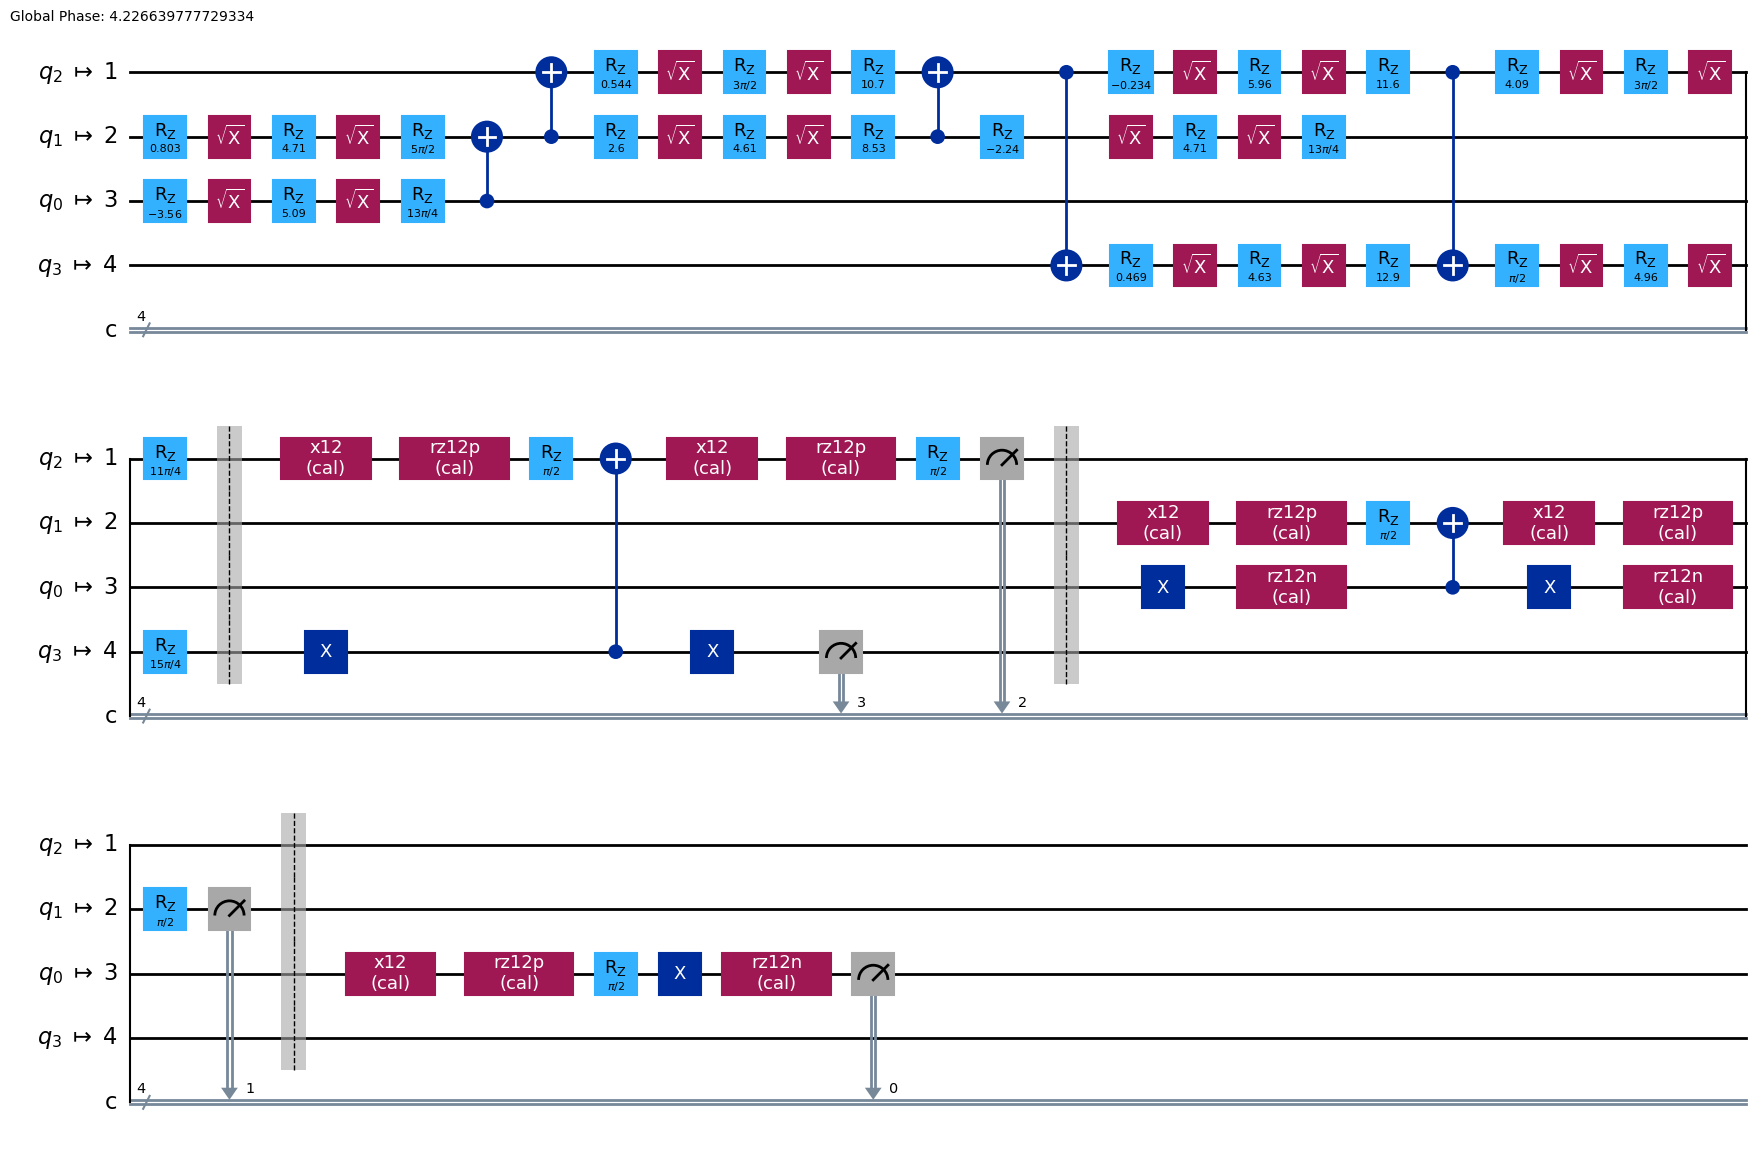

In [30]:
cir0().draw(idle_wires=False)

In [32]:
#C 0
from qiskit import QuantumCircuit, transpile, schedule, assemble

def cir1():
    
    c4 = QuantumCircuit(4,4)

    
    c4.u(p42[0][0],p42[0][1],p42[0][2],0)
    c4.u(p42[1][0],p42[1][1],p42[1][2],1)
    c4.cx(0,1)
    c4.cx(1,2)
    c4.u(p42[2][0],p42[2][1],p42[2][2],1)
    c4.u(p42[3][0],p42[3][1],p42[3][2],2)
    c4.cx(1,2)
    c4.u(p42[4][0],p42[4][1],p42[4][2],1)
    c4.cx(2,3)
    c4.u(p42[5][0],p42[5][1],p42[5][2],2)
    c4.u(p42[6][0],p42[6][1],p42[6][2],3)
    c4.cx(2,3)
    c4.u(p42[7][0],p42[7][1],p42[7][2],2)
    c4.u(p42[8][0],p42[8][1],p42[8][2],3)


#0-1 manifolds end here

    
    

    c4.barrier()

    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.cx(3,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
    
    
    c4.measure(2,2)
    c4.measure(3,3)
     
    c4.barrier()

    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.cx(0,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    
    c4.measure(1,1)
    
    
    c4.append(x12,[0])
    c4.append(rz12p,[0])
    c4.rz(np.pi/2,0)
    c4.x(0)
    c4.append(rz12n,[0])
    
    c4.x(0)
    c4.measure(0,0)

    
    
    c4.add_calibration("x12", qubits=[1], schedule=sched0)
    c4.add_calibration("x12", qubits=[2], schedule=sched1)
    c4.add_calibration("x12", qubits=[3], schedule=sched2)
    


    c4.add_calibration("rz12p", qubits=[1], schedule=rzpsched0)
    c4.add_calibration("rz12p", qubits=[2], schedule=rzpsched1)

    c4.add_calibration("rz12n", qubits=[1], schedule=rznsched0)
    c4.add_calibration("rz12n", qubits=[2], schedule=rznsched1)
    
    c4.add_calibration("rz12p", qubits=[3], schedule=rzpsched2)
    c4.add_calibration("rz12n", qubits=[3], schedule=rznsched2)

    c4= transpile(c4,backend=backend,initial_layout=[3,2,1,4])
    
    
    return c4
 




In [33]:
#C 0
from qiskit import QuantumCircuit, transpile, schedule, assemble

def cir2():
    
    c4 = QuantumCircuit(4,4)

    

    c4.u(p42[0][0],p42[0][1],p42[0][2],0)
    c4.u(p42[1][0],p42[1][1],p42[1][2],1)
    c4.cx(0,1)
    c4.cx(1,2)
    c4.u(p42[2][0],p42[2][1],p42[2][2],1)
    c4.u(p42[3][0],p42[3][1],p42[3][2],2)
    c4.cx(1,2)
    c4.u(p42[4][0],p42[4][1],p42[4][2],1)
    c4.cx(2,3)
    c4.u(p42[5][0],p42[5][1],p42[5][2],2)
    c4.u(p42[6][0],p42[6][1],p42[6][2],3)
    c4.cx(2,3)
    c4.u(p42[7][0],p42[7][1],p42[7][2],2)
    c4.u(p42[8][0],p42[8][1],p42[8][2],3)
    

#0-1 manifolds end here

    
    
    
    c4.barrier()

    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.cx(3,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
   
    
    c4.measure(2,2)
    c4.measure(3,3)
    c4.barrier()
    
    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.cx(0,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    
    
   
    c4.x(1)
    
    
    c4.measure(1,1)
    
    c4.barrier()

    c4.append(x12,[0])
    c4.append(rz12p,[0])
    c4.rz(np.pi/2,0)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.measure(0,0)

    
    
    c4.add_calibration("x12", qubits=[1], schedule=sched0)
    c4.add_calibration("x12", qubits=[2], schedule=sched1)
    c4.add_calibration("x12", qubits=[3], schedule=sched2)
    


    c4.add_calibration("rz12p", qubits=[1], schedule=rzpsched0)
    c4.add_calibration("rz12p", qubits=[2], schedule=rzpsched1)

    c4.add_calibration("rz12n", qubits=[1], schedule=rznsched0)
    c4.add_calibration("rz12n", qubits=[2], schedule=rznsched1)

    c4.add_calibration("rz12p", qubits=[3], schedule=rzpsched2)
    c4.add_calibration("rz12n", qubits=[3], schedule=rznsched2)
    
    c4= transpile(c4,backend=backend,initial_layout=[3,2,1,4])
    
    
    return c4
 




In [34]:
#C 0
from qiskit import QuantumCircuit, transpile, schedule, assemble

def cir3():
    
    c4 = QuantumCircuit(4,4)

    

    c4.u(p42[0][0],p42[0][1],p42[0][2],0)
    c4.u(p42[1][0],p42[1][1],p42[1][2],1)
    c4.cx(0,1)
    c4.cx(1,2)
    c4.u(p42[2][0],p42[2][1],p42[2][2],1)
    c4.u(p42[3][0],p42[3][1],p42[3][2],2)
    c4.cx(1,2)
    c4.u(p42[4][0],p42[4][1],p42[4][2],1)
    c4.cx(2,3)
    c4.u(p42[5][0],p42[5][1],p42[5][2],2)
    c4.u(p42[6][0],p42[6][1],p42[6][2],3)
    c4.cx(2,3)
    c4.u(p42[7][0],p42[7][1],p42[7][2],2)
    c4.u(p42[8][0],p42[8][1],p42[8][2],3)


#0-1 manifolds end here

    
    
    
    c4.barrier()

    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.cx(3,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
    
    
    c4.measure(2,2)
    c4.measure(3,3)

    c4.barrier()

    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.cx(0,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    
   
    c4.x(1)
    
    
    c4.measure(1,1)
    
    c4.barrier()
    
    
    c4.append(x12,[0])
    c4.append(rz12p,[0])
    c4.rz(np.pi/2,0)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.x(0)
    
    c4.measure(0,0)

    
    
    c4.add_calibration("x12", qubits=[1], schedule=sched0)
    c4.add_calibration("x12", qubits=[2], schedule=sched1)
    c4.add_calibration("x12", qubits=[3], schedule=sched2)
    


    c4.add_calibration("rz12p", qubits=[1], schedule=rzpsched0)
    c4.add_calibration("rz12p", qubits=[2], schedule=rzpsched1)

    c4.add_calibration("rz12n", qubits=[1], schedule=rznsched0)
    c4.add_calibration("rz12n", qubits=[2], schedule=rznsched1)
    
    c4.add_calibration("rz12p", qubits=[3], schedule=rzpsched2)
    c4.add_calibration("rz12n", qubits=[3], schedule=rznsched2)

    c4= transpile(c4,backend=backend,initial_layout=[3,2,1,4])
    
    
    return c4
 




In [35]:
#C 0
from qiskit import QuantumCircuit, transpile, schedule, assemble

def cir4():
    
    c4 = QuantumCircuit(4,4)

    

    c4.u(p42[0][0],p42[0][1],p42[0][2],0)
    c4.u(p42[1][0],p42[1][1],p42[1][2],1)
    c4.cx(0,1)
    c4.cx(1,2)
    c4.u(p42[2][0],p42[2][1],p42[2][2],1)
    c4.u(p42[3][0],p42[3][1],p42[3][2],2)
    c4.cx(1,2)
    c4.u(p42[4][0],p42[4][1],p42[4][2],1)
    c4.cx(2,3)
    c4.u(p42[5][0],p42[5][1],p42[5][2],2)
    c4.u(p42[6][0],p42[6][1],p42[6][2],3)
    c4.cx(2,3)
    c4.u(p42[7][0],p42[7][1],p42[7][2],2)
    c4.u(p42[8][0],p42[8][1],p42[8][2],3)


#0-1 manifolds end here

    
    
    
    c4.barrier()

    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.cx(3,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
   
    c4.x(2)
    
    c4.measure(2,2)
    c4.measure(3,3)

    c4.barrier()

    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.cx(0,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    
    
   
    
    
    
    c4.measure(1,1)
    c4.barrier()
    
    c4.append(x12,[0])
    c4.append(rz12p,[0])
    c4.rz(np.pi/2,0)
    c4.x(0)
    c4.append(rz12n,[0])
    
    c4.measure(0,0)

    
    
    c4.add_calibration("x12", qubits=[1], schedule=sched0)
    c4.add_calibration("x12", qubits=[2], schedule=sched1)
    c4.add_calibration("x12", qubits=[3], schedule=sched2)
    


    c4.add_calibration("rz12p", qubits=[1], schedule=rzpsched0)
    c4.add_calibration("rz12p", qubits=[2], schedule=rzpsched1)

    c4.add_calibration("rz12n", qubits=[1], schedule=rznsched0)
    c4.add_calibration("rz12n", qubits=[2], schedule=rznsched1)
    
    c4.add_calibration("rz12p", qubits=[3], schedule=rzpsched2)
    c4.add_calibration("rz12n", qubits=[3], schedule=rznsched2)

    c4= transpile(c4,backend=backend,initial_layout=[3,2,1,4])
    
    
    return c4
 




In [36]:
#C 0
from qiskit import QuantumCircuit, transpile, schedule, assemble

def cir5():
    
    c4 = QuantumCircuit(4,4)

    
    c4.u(p42[0][0],p42[0][1],p42[0][2],0)
    c4.u(p42[1][0],p42[1][1],p42[1][2],1)
    c4.cx(0,1)
    c4.cx(1,2)
    c4.u(p42[2][0],p42[2][1],p42[2][2],1)
    c4.u(p42[3][0],p42[3][1],p42[3][2],2)
    c4.cx(1,2)
    c4.u(p42[4][0],p42[4][1],p42[4][2],1)
    c4.cx(2,3)
    c4.u(p42[5][0],p42[5][1],p42[5][2],2)
    c4.u(p42[6][0],p42[6][1],p42[6][2],3)
    c4.cx(2,3)
    c4.u(p42[7][0],p42[7][1],p42[7][2],2)
    c4.u(p42[8][0],p42[8][1],p42[8][2],3)


#0-1 manifolds end here

    
    
    
    c4.barrier()

    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.cx(3,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
    
    c4.x(2)
    
    c4.measure(2,2)
    c4.measure(3,3)

    c4.barrier()

    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.cx(0,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    
    
    
    c4.measure(1,1)
    c4.barrier()
    
    c4.append(x12,[0])
    c4.append(rz12p,[0])
    c4.rz(np.pi/2,0)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.x(0)
    
    c4.measure(0,0)

    
    
    c4.add_calibration("x12", qubits=[1], schedule=sched0)
    c4.add_calibration("x12", qubits=[2], schedule=sched1)
    c4.add_calibration("x12", qubits=[3], schedule=sched2)
    


    c4.add_calibration("rz12p", qubits=[1], schedule=rzpsched0)
    c4.add_calibration("rz12p", qubits=[2], schedule=rzpsched1)

    c4.add_calibration("rz12n", qubits=[1], schedule=rznsched0)
    c4.add_calibration("rz12n", qubits=[2], schedule=rznsched1)
    
    c4.add_calibration("rz12p", qubits=[3], schedule=rzpsched2)
    c4.add_calibration("rz12n", qubits=[3], schedule=rznsched2)

    c4= transpile(c4,backend=backend,initial_layout=[3,2,1,4])
    
    
    return c4
 




In [37]:
#C 0
from qiskit import QuantumCircuit, transpile, schedule, assemble

def cir6():
    
    c4 = QuantumCircuit(4,4)

    

    c4.u(p42[0][0],p42[0][1],p42[0][2],0)
    c4.u(p42[1][0],p42[1][1],p42[1][2],1)
    c4.cx(0,1)
    c4.cx(1,2)
    c4.u(p42[2][0],p42[2][1],p42[2][2],1)
    c4.u(p42[3][0],p42[3][1],p42[3][2],2)
    c4.cx(1,2)
    c4.u(p42[4][0],p42[4][1],p42[4][2],1)
    c4.cx(2,3)
    c4.u(p42[5][0],p42[5][1],p42[5][2],2)
    c4.u(p42[6][0],p42[6][1],p42[6][2],3)
    c4.cx(2,3)
    c4.u(p42[7][0],p42[7][1],p42[7][2],2)
    c4.u(p42[8][0],p42[8][1],p42[8][2],3)

#0-1 manifolds end here

    
    

    c4.barrier()

    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.cx(3,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
   
    c4.x(2)
    
    c4.measure(2,2)
    c4.measure(3,3)
    
    c4.barrier()
    
    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.cx(0,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    
 
    c4.x(1)
    

    c4.measure(1,1)
    
    c4.barrier()
    
    c4.append(x12,[0])
    c4.append(rz12p,[0])
    c4.rz(np.pi/2,0)
    c4.x(0)
    c4.append(rz12n,[0])
    
    c4.measure(0,0)

    
    
    c4.add_calibration("x12", qubits=[1], schedule=sched0)
    c4.add_calibration("x12", qubits=[2], schedule=sched1)
    c4.add_calibration("x12", qubits=[3], schedule=sched2)
    


    c4.add_calibration("rz12p", qubits=[1], schedule=rzpsched0)
    c4.add_calibration("rz12p", qubits=[2], schedule=rzpsched1)

    c4.add_calibration("rz12n", qubits=[1], schedule=rznsched0)
    c4.add_calibration("rz12n", qubits=[2], schedule=rznsched1)
    
    c4.add_calibration("rz12p", qubits=[3], schedule=rzpsched2)
    c4.add_calibration("rz12n", qubits=[3], schedule=rznsched2)

    c4= transpile(c4,backend=backend,initial_layout=[3,2,1,4])
    
    
    return c4
 




In [38]:
#C 0
from qiskit import QuantumCircuit, transpile, schedule, assemble

def cir7():
    
    c4 = QuantumCircuit(4,4)

    
    c4.u(p42[0][0],p42[0][1],p42[0][2],0)
    c4.u(p42[1][0],p42[1][1],p42[1][2],1)
    c4.cx(0,1)
    c4.cx(1,2)
    c4.u(p42[2][0],p42[2][1],p42[2][2],1)
    c4.u(p42[3][0],p42[3][1],p42[3][2],2)
    c4.cx(1,2)
    c4.u(p42[4][0],p42[4][1],p42[4][2],1)
    c4.cx(2,3)
    c4.u(p42[5][0],p42[5][1],p42[5][2],2)
    c4.u(p42[6][0],p42[6][1],p42[6][2],3)
    c4.cx(2,3)
    c4.u(p42[7][0],p42[7][1],p42[7][2],2)
    c4.u(p42[8][0],p42[8][1],p42[8][2],3)


#0-1 manifolds end here

    
    
    
    c4.barrier()

    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.cx(3,2)
    c4.x(3)
    c4.append(rz12n,[3])
    c4.append(x12,[2])
    c4.append(rz12p,[2])
    c4.rz(np.pi/2,2)
    
    c4.x(2)
    
    c4.measure(2,2)
    c4.measure(3,3)
    
    c4.barrier()

    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.cx(0,1)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.append(x12,[1])
    c4.append(rz12p,[1])
    c4.rz(np.pi/2,1)
    
    
    c4.x(1)
    
    c4.measure(1,1)
    
    c4.barrier()

    c4.append(x12,[0])
    c4.append(rz12p,[0])
    c4.rz(np.pi/2,0)
    c4.x(0)
    c4.append(rz12n,[0])
    c4.x(0)
    c4.measure(0,0)

    
    
    c4.add_calibration("x12", qubits=[1], schedule=sched0)
    c4.add_calibration("x12", qubits=[2], schedule=sched1)
    c4.add_calibration("x12", qubits=[3], schedule=sched2)
    


    c4.add_calibration("rz12p", qubits=[1], schedule=rzpsched0)
    c4.add_calibration("rz12p", qubits=[2], schedule=rzpsched1)

    c4.add_calibration("rz12n", qubits=[1], schedule=rznsched0)
    c4.add_calibration("rz12n", qubits=[2], schedule=rznsched1)
    
    c4.add_calibration("rz12p", qubits=[3], schedule=rzpsched2)
    c4.add_calibration("rz12n", qubits=[3], schedule=rznsched2)

    c4= transpile(c4,backend=backend,initial_layout=[3,2,1,4])
    
    
    return c4
 




In [39]:
qc0,qc1,qc2,qc3,qc10,qc11,qc12,qc13 = cir0(),cir1(),cir2(),cir3(),cir4(),cir5(),cir6(),cir7()

In [40]:
qc0.calibrations

{'x12': {((1,),
   ()): ScheduleBlock(ScheduleBlock(SetFrequency(4813128811.352196, ControlChannel(1)), Play(Drag(duration=144, sigma=36, beta=0.268273, amp=0.14905906, angle=0.0), ControlChannel(1)), SetFrequency(5155117111.352196, ControlChannel(1)), name="block1", transform=AlignSequential()), name="x12", transform=AlignLeft()),
  ((2,),
   ()): ScheduleBlock(ScheduleBlock(SetFrequency(4916867380.292746, ControlChannel(4)), Play(Drag(duration=144, sigma=36, beta=-1.31573, amp=0.1654836, angle=0.0), ControlChannel(4)), SetFrequency(5256351980.292746, ControlChannel(4)), name="block7", transform=AlignSequential()), name="x12", transform=AlignLeft()),
  ((3,),
   ()): ScheduleBlock(ScheduleBlock(SetFrequency(4754706893.221984, ControlChannel(7)), Play(Drag(duration=144, sigma=36, beta=-0.3049934, amp=0.2011839, angle=0.0), ControlChannel(7)), SetFrequency(5097449193.221984, ControlChannel(7)), name="block15", transform=AlignSequential()), name="x12", transform=AlignLeft())},
 'rz12p': 

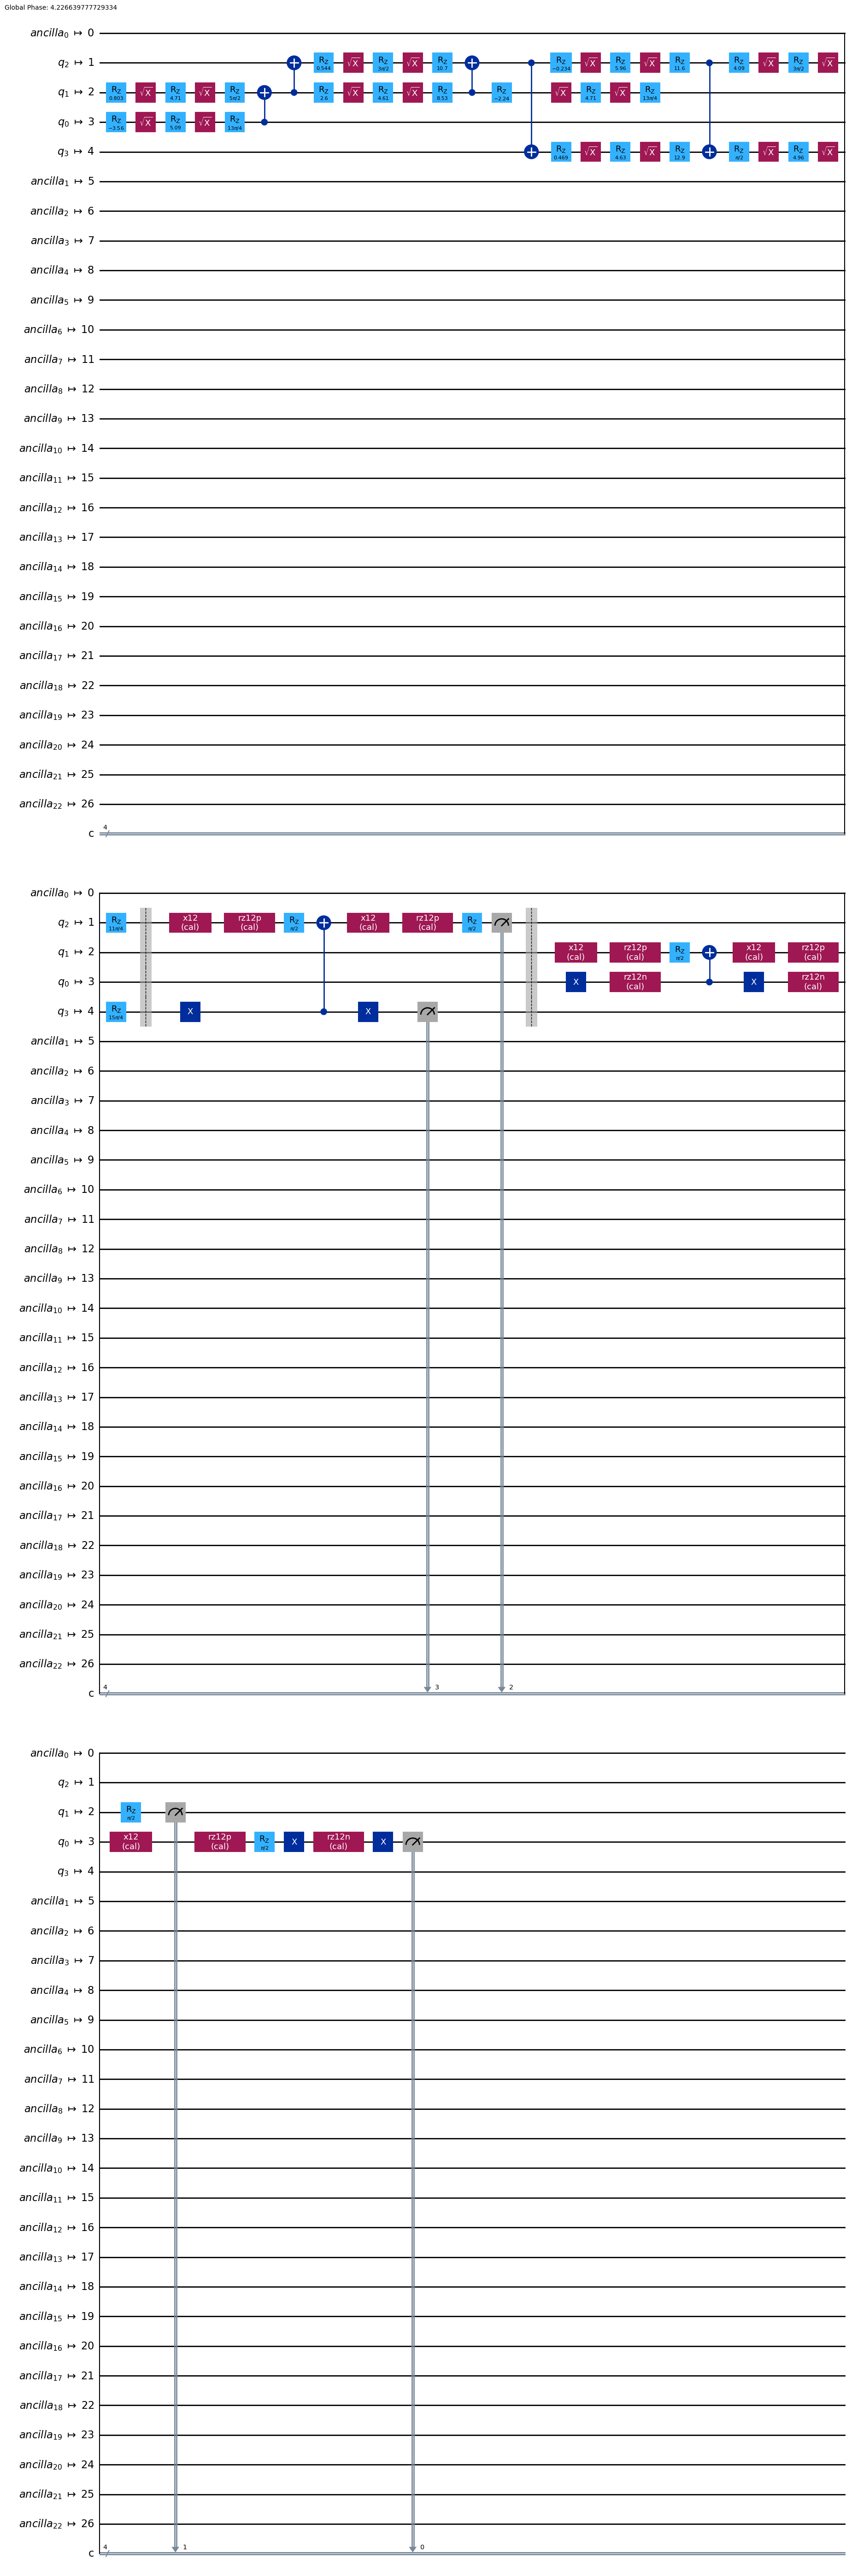

In [41]:
qc1.draw("mpl",filename="4TGS2.pdf")

In [42]:
backend

<IBMBackend('ibm_hanoi')>

In [43]:
# from qiskit import execute

# job = execute([qc0,qc1,qc2,qc3], backend=backend, shots=4000)

from math import pi
from qiskit_ibm_runtime import Session, Estimator, Sampler, Options
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options
service = QiskitRuntimeService()

options = Options(simulator={"seed_simulator": 42},resilience_level=0) # NO ERROR MITIGATION

with Session(service=service, backend='ibm_hanoi'):
    sampler = Sampler() # Define sampler with options above
    job = sampler.run(circuits=[qc0,qc1,qc2,qc3,qc10,qc11,qc12,qc13],skip_transpilation=True, shots =10**3) # build your code here
    print(job.job_id())

qiskit_runtime_service.__init__:INFO:2024-04-14 12:17:00,780: Default instance: ibm-q-ornl/ornl/cph140
base_primitive._run_primitive:INFO:2024-04-14 12:17:04,247: Submitting job using options {'optimization_level': 1, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}


crdwjganzrx00081vtxg


In [3]:
#Extracting the jobs

from math import pi
from qiskit_ibm_runtime import Session, Estimator, Sampler, Options
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options



job = service.job('crdwjganzrx00081vtxg')

Result = job.result()
Result

SamplerResult(quasi_dists=[{1: 0.004308867102693, 2: 0.000599815722286, 3: 0.005042193588139, 4: 0.011974205232015, 5: 0.328695937173907, 6: 0.014434724472116, 7: 0.252308801534503, 8: 0.001607985046168, 9: 0.015545619434886, 10: 0.00773925334193, 11: 0.192001772621068, 12: 0.001894441374195, 13: 0.108126223185225, 14: 0.003471552157222, 15: 0.052248608013648}, {1: 0.001789387796982, 2: -0.000772563321985, 3: 0.003442635892966, 4: 0.006832858205445, 5: 0.307766914197049, 6: 0.162988427092192, 7: 0.148557471579107, 8: -0.002022437140966, 9: 0.005287928695832, 10: 0.098700316776166, 11: 0.117301844057361, 12: 0.005515193745462, 13: 0.101095399337637, 14: 0.026810047219523, 15: 0.01670657586723}, {0: 0.000667333102837, 1: 0.003789198716558, 3: 0.007596654912823, 4: 0.010071111711773, 5: 0.168807046030664, 6: 0.025340172101955, 7: 0.412332154010641, 8: 0.009283518854154, 9: 0.107895252015539, 10: 0.003030553783932, 11: 0.09997481094118, 12: 0.005587896406695, 13: 0.023970408950913, 14: 0.0

In [4]:
R = [Result.quasi_dists[i].binary_probabilities() for i in range(8)]


In [5]:
#Expected probability wave vector
Q = [(0j, '000'),
 (0j, '0001'),
 (0j, '0002'),
 (0j, '0010'),
 (0j, '0011'),
 (0j, '0012'),
 (0j, '0020'),
 (0j, '0021'),
 (0j, '0022'),
 (0j, '0100'),
 (0j, '0101'),
 (-0j, '0102'),
 (0j, '0110'),
 ((-0+0j), '0111'),
 ((0.31235-0j), '0112'),
 (0j, '0120'),
 ((-0.31235+0j), '0121'),
 (0j, '0122'),
 (0j, '0200'),
 (0j, '0201'),
 ((-0.6247+0j), '0202'),
 (0j, '0210'),
 ((0.31235-0j), '0211'),
 (0j, '0212'),
 (0j, '0220'),
 (-0j, '0221'),
 (0j, '0222'),
 (0j, '1000'),
 (0j, '1001'),
 (-0j, '1002'),
 (0j, '1010'),
 ((-0+0j), '1011'),
 ((-0.31235+0j), '1012'),
 (0j, '1020'),
 ((0.31235-0j), '1021'),
 (0j, '1022'),
 (0j, '1100'),
 (0j, '1101'),
 ((0.31235-0j), '1102'),
 (0j, '1110'),
 ((-0.15617+0j), '1111'),
 ((-0+0j), '1112'),
 (0j, '1120'),
 ((-0-0j), '1121'),
 (0j, '1122'),
 (0j, '1200'),
 (0j, '1201'),
 (0j, '1202'),
 (0j, '1210'),
 (0j, '1211'),
 (0j, '1212'),
 (0j, '1220'),
 (0j, '1221'),
 (0j, '1222'),
 (0j, '2000'),
 (0j, '2001'),
 (0j, '2002'),
 (0j, '2010'),
 (0j, '2011'),
 (0j, '2012'),
 (0j, '2020'),
 (0j, '2021'),
 (0j, '2022'),
 (0j, '2100'),
 (0j, '2101'),
 (0j, '2102'),
 (0j, '2110'),
 (0j, '2111'),
 (0j, '2112'),
 (0j, '2120'),
 (0j, '2121'),
 (0j, '2122'),
 (0j, '2200'),
 (0j, '2201'),
 (0j, '2202'),
 (0j, '2210'),
 (0j, '2211'),
 (0j, '2212'),
 (0j, '2220'),
 (0j, '2221'),
 (0j, '2222')]

import numpy as np
q = [np.abs(Q[i][0])**2  for i in range(81)]

In [6]:
#Fidelity cell for n=3

#Initialise 3x1 arrays each for the thirs qutrit in '0', '1' and '2'. In each of these subarrays (say '0'),
#we have a 2 qutrit system whose fidelity we know how to calculate 

import numpy as np

p00 = np.zeros(3)

p01 = np.zeros(3)

p10 = np.zeros(3)

p11 = np.zeros(3)

p02 = np.zeros(3)

p20 = np.zeros(3)

p12 = np.zeros(3)

p21 = np.zeros(3)

p22 = np.zeros(3)

#'0' sector


    
p00[0] =  R[0].get('0000')  #== P['000']

p00[0] = 0  # Fixes



tp01 = R[0].get('0001') #== P['001'] + P['002'] 

tp10 = R[0].get('0010')  #== P['010'] + P['020'] 


tp11 = R[0].get('0011') #== P['011'] + P['012'] + P['021'] + P['022']  

p01[0] = R[1].get('0000') #== P['001']

p01[0] = 0  # Fixes


p10[0] = R[2].get('0000') #== P['010']

p11[0] = R[3].get('0000') #== P['011']



p02[0] = tp01 - p01[0] #== P['002']



p20[0] = tp10 - p10[0] #== P['020']

fp01 = R[3].get('0001') 
fp10 = R[3].get('0010')

p12[0] = fp01 - p10[0] #== P['012']

p21[0] = fp10 - p01[0] #== P['021']

p22[0] = p00[0] + tp01 + tp10 + tp11 -(p00[0] + p01[0] + p02[0] + p10[0] + p11[0] + p12[0] + p20[0] + p21[0]) #== P['022']

# "1" sector

p00[1] =  R[4].get('0000')  #== P['100']

tp01 = R[4].get('0001') #== P['101'] + P['002'] 

tp10 = R[4].get('0010') #== P['110'] + P['020'] 

tp11 = R[4].get('0011') #== P['111'] + P['112'] + P['121'] + P['122']  

p01[1] = R[5].get('0000') #== P['101']  

p10[1] = R[6].get('0000') #== P['110']

p11[1] = R[7].get('0000') #== P['111']

p02[1] = tp01 - p01[1] #== P['102']

p20[1] = tp10 - p10[1] #== P['120']

fp01 = R[7].get('0001') 
fp10 = R[7].get('0010') 

p12[1] = fp01 - p10[1] #== P['112']

p21[1] = fp10 - p01[1] #== P['121']

p22[1] = p00[1] + tp01 + tp10 + tp11 -(p00[1] + p01[1] + p02[1] + p10[1]+ p11[1] + p12[1] + p20[1] + p21[1]) #== P['122']


# "1+2" sector, we will subtract this from "1" sector. So I have named the first entry c = '1+2'

p00[2] =  R[0].get('0100')  #== P['c00']

tp01 = R[0].get('0101') #== P['c01'] + P['c02'] 

tp10 = R[0].get('0110') #== P['c10'] + P['c20'] 

tp11 = R[0].get('0111') #== P['c11'] + P['c12'] + P['c21'] + P['c22']  

p01[2] = R[1].get('0100') #== P['001']  

p10[2] = R[2].get('0100') #== P['010']



p11[2] = R[3].get('0100') #== P['011']

p02[2] = tp01 - p01[2] #== P['002']

p20[2] = tp10 - p10[2] #== P['020']

fp01 = R[3].get('0101') 
fp10 = R[3].get('0110') 

p12[2] = fp01 - p10[2]


p21[2] = fp10 - p01[2]


p22[2] = p00[2] + tp01 + tp10 + tp11 -(p00[2] + p01[2] + p02[2] + p10[2] + p11[2] + p12[2] + p20[2] + p21[2])

# Subtracting "1" from "1+2" sector

p00[2] = p00[2] - p00[1]
p01[2] = p01[2] - p01[1]
p10[2] = p10[2] - p10[1]
p11[2] = p11[2] - p11[1]

p02[2] = p02[2] - p02[1]
p20[2] = p20[2] - p20[1]
p12[2] = p12[2] - p12[1]
p21[2] = p21[2] - p21[1]



p22[2] = p22[2] - p22[1]


P1 = [p00[0] , p01[0] , p02[0] , p10[0], p11[0] , p12[0] , p20[0] , p21[0], p22[0], 
                     p00[1] , p01[1] , p02[1] ,p10[1], p11[1] , p12[1] , p20[1] ,p21[1], p22[1],
                     p00[2] , p01[2] , p02[2] ,p10[2], p11[2] , p12[2] , p20[2] ,p21[2], p22[2]]

In [7]:
P1

[0.0,
 0.0,
 0.004308867102692571,
 0.0006673331028372053,
 -0.0005978802378714285,
 0.002147439347997455,
 -6.751738055083359e-05,
 0.0038693849352340395,
 -0.0003767504572212074,
 0.0015682255964661062,
 -0.0017312964262017247,
 0.012125014102092374,
 0.0022046753207597527,
 0.0031067688369807787,
 0.07724795495053702,
 0.004457833043164571,
 0.07417806294854075,
 0.00786894590246967,
 0.01040597963554896,
 0.008564154631646512,
 0.30973806486636957,
 0.007866436391013528,
 0.0767735510850178,
 0.01981940296203416,
 -9.422028282231581e-05,
 0.006904052273571576,
 -0.013589937424648424]

In [8]:
#Fidelity cell for n=3

#Initialise 3x1 arrays each for the thirs qutrit in '0', '1' and '2'. In each of these subarrays (say '0'),
#we have a 2 qutrit system whose fidelity we know how to calculate 

import numpy as np

p00 = np.zeros(3)

p01 = np.zeros(3)

p10 = np.zeros(3)

p11 = np.zeros(3)

p02 = np.zeros(3)

p20 = np.zeros(3)

p12 = np.zeros(3)

p21 = np.zeros(3)

p22 = np.zeros(3)

#'0' sector


p00[0] =  R[0].get('1000')  #== P['000']

tp01 = R[0].get('1001') #== P['001'] + P['002'] 

tp10 = R[0].get('1010')  #== P['010'] + P['020'] 

tp11 = R[0].get('1011') #== P['011'] + P['012'] + P['021'] + P['022']  

p01[0] = R[1].get('1000') #== P['001']  

p10[0] = R[2].get('1000') #== P['010']

p11[0] = R[3].get('1000') #== P['011']

p02[0] = tp01 - p01[0] #== P['002']

p20[0] = tp10 - p10[0] #== P['020']

fp01 = R[3].get('1001') 
fp10 = R[3].get('1010')

p12[0] = fp01 - p10[0] #== P['012']

p21[0] = fp10 - p01[0] #== P['021']

p22[0] = p00[0] + tp01 + tp10 + tp11 -(p00[0] + p01[0] + p02[0] + p10[0] + p11[0] + p12[0] + p20[0] + p21[0]) #== P['022']

# "1" sector

p00[1] =  R[4].get('1000')  #== P['100']

tp01 = R[4].get('1001') #== P['101'] + P['002'] 

tp10 = R[4].get('1010') #== P['110'] + P['020'] 

tp11 = R[4].get('1011') #== P['111'] + P['112'] + P['121'] + P['122']  

p01[1] = R[5].get('1000') #== P['101']  
p01[1] = 0  # Fixes

p10[1] = R[6].get('1000') #== P['110']

p11[1] = R[7].get('1000') #== P['111']

p02[1] = tp01 - p01[1] #== P['102']

p20[1] = tp10 - p10[1] #== P['120']

fp01 = R[7].get('1001') 
fp10 = R[7].get('1010') 

p12[1] = fp01 - p10[1] #== P['112']

p21[1] = fp10 - p01[1] #== P['121']

p22[1] = p00[1] + tp01 + tp10 + tp11 -(p00[1] + p01[1] + p02[1] + p10[1]+ p11[1] + p12[1] + p20[1] + p21[1]) #== P['122']


# "1+2" sector, we will subtract this from "1" sector. So I have named the first entry c = '1+2'

p00[2] =  R[0].get('1100')  #== P['c00']

tp01 = R[0].get('1101') #== P['c01'] + P['c02'] 

tp10 = R[0].get('1110') #== P['c10'] + P['c20'] 

tp11 = R[0].get('1111') #== P['c11'] + P['c12'] + P['c21'] + P['c22']  

p01[2] = R[1].get('1100') #== P['001']  

p10[2] = R[2].get('1100') #== P['010']



p11[2] = R[3].get('1100') #== P['011']

p02[2] = tp01 - p01[2] #== P['002']

p20[2] = tp10 - p10[2] #== P['020']

fp01 = R[3].get('1101') 
fp10 = R[3].get('1110') 

p12[2] = fp01 - p10[2]


p21[2] = fp10 - p01[2]


p22[2] = p00[2] + tp01 + tp10 + tp11 -(p00[2] + p01[2] + p02[2] + p10[2] + p11[2] + p12[2] + p20[2] + p21[2])

# Subtracting "1" from "1+2" sector

p00[2] = p00[2] - p00[1]
p01[2] = p01[2] - p01[1]
p10[2] = p10[2] - p10[1]
p11[2] = p11[2] - p11[1]

p02[2] = p02[2] - p02[1]
p20[2] = p20[2] - p20[1]
p12[2] = p12[2] - p12[1]
p21[2] = p21[2] - p21[1]



p22[2] = p22[2] - p22[1]


P2 = [p00[0] , p01[0] , p02[0] , p10[0], p11[0] , p12[0] , p20[0] , p21[0], p22[0], 
                     p00[1] , p01[1] , p02[1] ,p10[1], p11[1] , p12[1] , p20[1] ,p21[1], p22[1],
                     p00[2] , p01[2] , p02[2] ,p10[2], p11[2] , p12[2] , p20[2] ,p21[2], p22[2]]

In [9]:
P2

[0.0016079850461678986,
 -0.0020224371409655636,
 0.017568056575851164,
 0.009283518854153554,
 0.003677560861743609,
 0.10352490541582239,
 -0.0015442655122231055,
 0.07940173931736724,
 0.005397567026134559,
 0.0034738564984311037,
 0.0,
 0.06975785247447072,
 0.0005731758001921971,
 0.019491323118392644,
 0.0030223025573719005,
 0.0010127942500486983,
 0.0013486648486110103,
 0.010944420700281246,
 -0.0015794151242358983,
 0.005515193745461546,
 0.03285317696529233,
 0.005014720606503269,
 0.0014038836287755124,
 -0.0030354348260615716,
 -0.0031291384995222236,
 0.004878209484173789,
 0.01419523850210351]

In [10]:
P3 = np.zeros(27)
P3

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
p = P1+P2+list(P3)
p

[0.0,
 0.0,
 0.004308867102692571,
 0.0006673331028372053,
 -0.0005978802378714285,
 0.002147439347997455,
 -6.751738055083359e-05,
 0.0038693849352340395,
 -0.0003767504572212074,
 0.0015682255964661062,
 -0.0017312964262017247,
 0.012125014102092374,
 0.0022046753207597527,
 0.0031067688369807787,
 0.07724795495053702,
 0.004457833043164571,
 0.07417806294854075,
 0.00786894590246967,
 0.01040597963554896,
 0.008564154631646512,
 0.30973806486636957,
 0.007866436391013528,
 0.0767735510850178,
 0.01981940296203416,
 -9.422028282231581e-05,
 0.006904052273571576,
 -0.013589937424648424,
 0.0016079850461678986,
 -0.0020224371409655636,
 0.017568056575851164,
 0.009283518854153554,
 0.003677560861743609,
 0.10352490541582239,
 -0.0015442655122231055,
 0.07940173931736724,
 0.005397567026134559,
 0.0034738564984311037,
 0.0,
 0.06975785247447072,
 0.0005731758001921971,
 0.019491323118392644,
 0.0030223025573719005,
 0.0010127942500486983,
 0.0013486648486110103,
 0.010944420700281246,
 

In [13]:
import numpy as np

def hellinger_fidelity(p, q):
    """
    Compute the Hellinger Fidelity between two probability distributions p and q.
    
    Parameters:
    p (list or numpy array): First probability distribution.
    q (list or numpy array): Second probability distribution.
    
    Returns:
    float: Hellinger Fidelity between the distributions.
    """
    p = [np.max([p[i],0]) for i in range(len(p))]
    q = [np.max([q[i],0]) for i in range(len(q))]
    
    assert len(p) == len(q), "Distributions must have the same length"
    
    return np.sum([np.sqrt(p[i]*q[i]) for i in range(len(p))])**2

# # Example usage
# p = [0.2, 0.3, 0.5]
# q = [0.25, 0.25, 0.5]
fidelity = hellinger_fidelity(p, q)
print("Hellinger Fidelity:", fidelity)

Hellinger Fidelity: 0.8080490477857378
